In [1]:
!pip install pyspark
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=8d9f020143083a18d76b0391b58ac09164299f97ddd50ea3511cbe0cef4a64c4
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [2]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
spark = SparkSession.builder.getOrCreate()

In [4]:
df = spark.read.csv("/content/BostonHousing-1.csv", header=True, inferSchema=True)

In [8]:
# Combine features to a single vector
feature_columns = df.columns[:-1]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df_assembled = assembler.transform(df)

In [7]:
df_assembled.show()

+-------+----+-----+----+-----+-----+-----+------+---+---+-------+------+-----+----+--------------------+
|   crim|  zn|indus|chas|  nox|   rm|  age|   dis|rad|tax|ptratio|     b|lstat|medv|            features|
+-------+----+-----+----+-----+-----+-----+------+---+---+-------+------+-----+----+--------------------+
|0.00632|18.0| 2.31|   0|0.538|6.575| 65.2|  4.09|  1|296|   15.3| 396.9| 4.98|24.0|[0.00632,18.0,2.3...|
|0.02731| 0.0| 7.07|   0|0.469|6.421| 78.9|4.9671|  2|242|   17.8| 396.9| 9.14|21.6|[0.02731,0.0,7.07...|
|0.02729| 0.0| 7.07|   0|0.469|7.185| 61.1|4.9671|  2|242|   17.8|392.83| 4.03|34.7|[0.02729,0.0,7.07...|
|0.03237| 0.0| 2.18|   0|0.458|6.998| 45.8|6.0622|  3|222|   18.7|394.63| 2.94|33.4|[0.03237,0.0,2.18...|
|0.06905| 0.0| 2.18|   0|0.458|7.147| 54.2|6.0622|  3|222|   18.7| 396.9| 5.33|36.2|[0.06905,0.0,2.18...|
|0.02985| 0.0| 2.18|   0|0.458| 6.43| 58.7|6.0622|  3|222|   18.7|394.12| 5.21|28.7|[0.02985,0.0,2.18...|
|0.08829|12.5| 7.87|   0|0.524|6.012| 66.6|5.5

In [6]:
# Standardize features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
scaler_model = scaler.fit(df_assembled)
df_scaled = scaler_model.transform(df_assembled)


In [9]:
df_scaled.show()

+-------+----+-----+----+-----+-----+-----+------+---+---+-------+------+-----+----+--------------------+--------------------+
|   crim|  zn|indus|chas|  nox|   rm|  age|   dis|rad|tax|ptratio|     b|lstat|medv|            features|     scaled_features|
+-------+----+-----+----+-----+-----+-----+------+---+---+-------+------+-----+----+--------------------+--------------------+
|0.00632|18.0| 2.31|   0|0.538|6.575| 65.2|  4.09|  1|296|   15.3| 396.9| 4.98|24.0|[0.00632,18.0,2.3...|[7.34751712931429...|
|0.02731| 0.0| 7.07|   0|0.469|6.421| 78.9|4.9671|  2|242|   17.8| 396.9| 9.14|21.6|[0.02731,0.0,7.07...|[0.00317501096205...|
|0.02729| 0.0| 7.07|   0|0.469|7.185| 61.1|4.9671|  2|242|   17.8|392.83| 4.03|34.7|[0.02729,0.0,7.07...|[0.00317268579840...|
|0.03237| 0.0| 2.18|   0|0.458|6.998| 45.8|6.0622|  3|222|   18.7|394.63| 2.94|33.4|[0.03237,0.0,2.18...|[0.00376327736512...|
|0.06905| 0.0| 2.18|   0|0.458|7.147| 54.2|6.0622|  3|222|   18.7| 396.9| 5.33|36.2|[0.06905,0.0,2.18...|[0.008

In [10]:
# Train model for two principal components
pca = PCA(k=2, inputCol="scaled_features", outputCol="pca_features")
pca_model = pca.fit(df_scaled)
df_pca = pca_model.transform(df_scaled)

In [11]:
# Collect distributed data in numpy array and then convert to pandas dataframe
pca_data = np.array(df_pca.select("pca_features").collect())
pca_data = np.stack(pca_data[:, 0])
pca_df = pd.DataFrame(data=pca_data, columns=["Principal Component 1", "Principal Component 2"])

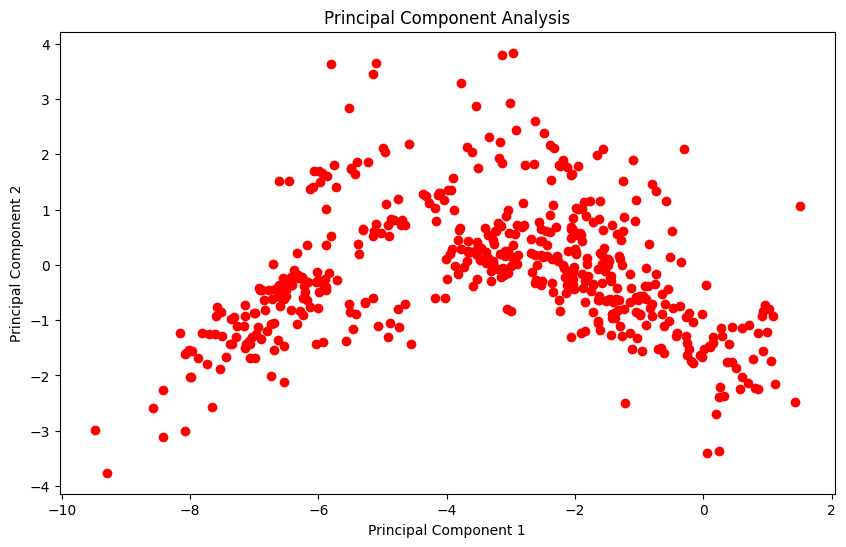

In [16]:
plt.figure(figsize=(10, 6))
plt.scatter(pca_df["Principal Component 1"], pca_df["Principal Component 2"], c='red')
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("Principal Component Analysis")
plt.show()


In [17]:
# Vectorize features and target together for model development
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df_vectorized = assembler.transform(df)
df_vectorized = df_vectorized.select("features", "medv")


In [18]:
# Split dataset into training and testing dataset
train_data, test_data = df_vectorized.randomSplit([0.8, 0.2], seed=1234)


In [19]:
# Fit model for linear regression
lr = LinearRegression(featuresCol="features", labelCol="medv")
lr_model = lr.fit(train_data)



In [20]:
# Evaluate model for test dataset
test_results = lr_model.evaluate(test_data)
print("RMSE: ", test_results.rootMeanSquaredError)
print("R2: ", test_results.r2)

RMSE:  5.042109954192658
R2:  0.600941723062131


In [21]:
# Extract predictions and actual values
predictions = test_results.predictions.select("prediction", "medv").toPandas()


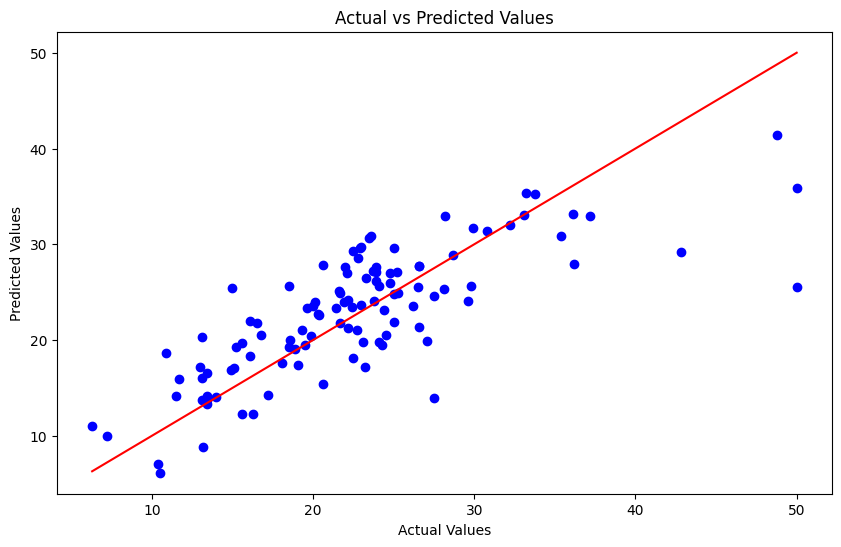

In [22]:
# Plot predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(predictions["medv"], predictions["prediction"], c='blue')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")
plt.plot([predictions["medv"].min(), predictions["medv"].max()], [predictions["medv"].min(), predictions["medv"].max()], color='red')
plt.show()